# Ternary model analysis

This notebook loads the most recent trained models, shows leaderboards, metrics, and renders plots (feature importance, confusion matrices).

In [290]:

from pathlib import Path
import os
import pandas as pd
from IPython.display import display, Markdown, Image

# Paths
ROOT = Path.cwd().parent  # notebooks -> upreg_classify
# Prefer the stacked model directory if available; fallback to the baseline multiclass dir
root = ROOT / 'models'


candidates = [
    ROOT / 'models' / 'cat_only_hpo4_no_bag',
    ROOT / 'models' / 'lgbm_only_subset_hpo',
    ROOT / 'models' / 'cat_only_subset_check', # denne ser ganske bra ut, og den er bare siden transition
    ROOT / 'models' / 'xgb_only_fixed_subset_check',
    ROOT / 'models' / 'xgb_only_full_fixed', # this is many many models
    ROOT / 'models' / 'multiclass_ag',
    ROOT / 'models' / 'inshallah_bag',
    ROOT / 'models' / 'cat_hpo_base_SICKo',
    ROOT / 'models' / 'quick_multiclass_cat_hpo',
    ROOT / 'models' / 'march2025_cat_no_tune',
    ROOT / 'models' / 'march2025_cat_only_240',
    ROOT / 'models' / 'march4_medium_cat',
    ROOT / 'models' / 'flows_exchange_quick_fix2',
    ROOT / 'models' / 'flows_exchange_quick',
    ROOT / 'models' / 'march2025_cat_only_240',
]

candidates = [
    root / 'quick_exclude_persistency_check',
    root / 'quick_eval_print_check2',
    root / 'quick_persistency_check',
]

MODELS = next((p for p in candidates if p.exists()), candidates[-1])
FIGS = ROOT / 'reports' / 'figures' / ('multiclass_stack' if MODELS.name == 'multiclass_stack_ag' else 'multiclass')

print(f"Models dir: {MODELS}")
print(f"Figures dir: {FIGS}")

assert MODELS.exists(), f"Missing models directory: {MODELS}"
FIGS.mkdir(parents=True, exist_ok=True)

Models dir: c:\PythonProjects\rl_reserve_markets\upreg_classify\models\quick_exclude_persistency_check
Figures dir: c:\PythonProjects\rl_reserve_markets\upreg_classify\reports\figures\multiclass


In [291]:
# Load predictor and show leaderboard
from autogluon.tabular import TabularPredictor

predictor = TabularPredictor.load(MODELS)
display(Markdown('### Leaderboard'))
try:
    lb = predictor.leaderboard(silent=True)
    display(lb)
except Exception as e:
    print("leaderboard() failed:", e)

### Leaderboard

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.456611,f1_macro,0.017189,10.162318,0.000000,0.071331,2,True,6
1,CatBoost\T3,0.456611,f1_macro,0.017189,10.090987,0.017189,10.090987,1,True,3
2,CatBoost\T5,0.442289,f1_macro,0.005617,12.199604,0.005617,12.199604,1,True,5
3,CatBoost\T2,0.439793,f1_macro,0.004844,9.483947,0.004844,9.483947,1,True,2
4,CatBoost\T1,0.434910,f1_macro,0.012140,11.486860,0.012140,11.486860,1,True,1
5,CatBoost\T4,0.430530,f1_macro,0.008594,18.742998,0.008594,18.742998,1,True,4


In [292]:
# Read and display metrics and classification reports
import json

display(Markdown('### Metrics table'))
metrics_csv = MODELS / 'metrics.csv'
if metrics_csv.exists():
    metrics_df = pd.read_csv(metrics_csv)
    display(metrics_df)
else:
    print('metrics.csv not found:', metrics_csv)

### Metrics table

,val_f1_macro,val_accuracy,val_nll,val_brier,val_ece_top1_10bins,test_f1_macro,test_accuracy,test_nll,test_brier,test_ece_top1_10bins
0,0.529873,0.610173,0.851351,0.506222,0.036189,0.594401,0.631853,0.859809,0.508755,0.017263


In [293]:
# open reports/dataframes/multiclass_dataset.csv
df = pd.read_csv(ROOT / 'reports' / 'dataframes' / 'multiclass_dataset.csv')
print(len(df), "rows in multiclass_dataset.csv")
df.head(2)

14391 rows in multiclass_dataset.csv


,NO1-NO2_ratio,NO1-NO2_ratio_dup1,NO1-NO3_ratio,NO1-NO3_ratio_dup1,NO1-NO5_ratio,NO1-NO5_ratio_dup1,NO1-SE3_ratio,NO1-SE3_ratio_dup1,Accepted Up Share,Accepted Imbalance Ratio,...,PriceUp - DA,PriceUp/DA Ratio,PriceDown - DA,PriceDown/DA Ratio,Total Imports,Net Import,Import/Consumption,Residual Load,Residual Load Delta,Net Import Ramp
0,0.791818,0.791818,0.414,0.414,0.326154,0.326154,0.871122,0.871122,0.227194,-0.544482,...,2.72,1.080118,2.72,1.080118,3583.0,1846.0,0.415018,4181.0,-310.0,64.0
1,0.785000,0.785000,0.378,0.378,0.331538,0.331538,0.871122,0.871122,0.308679,-0.381535,...,2.79,1.082180,2.79,1.082180,3550.0,1773.0,0.398606,4181.0,0.0,-73.0


## Feature importance (top 30)

,feature,importance
0,RegLag-4,0.030119
1,DA Price,0.015336
2,RegLag-6,0.013404
3,RegLagCat-4,0.009223
4,RegLagCat-6,0.008201
5,NO1-NO3_ratio,0.006814
6,PriceUp/DA Ratio,0.006712
7,Up-Down Price Skew,0.006394
8,PriceUp - DA,0.006070
9,RegLagCat-10,0.005584


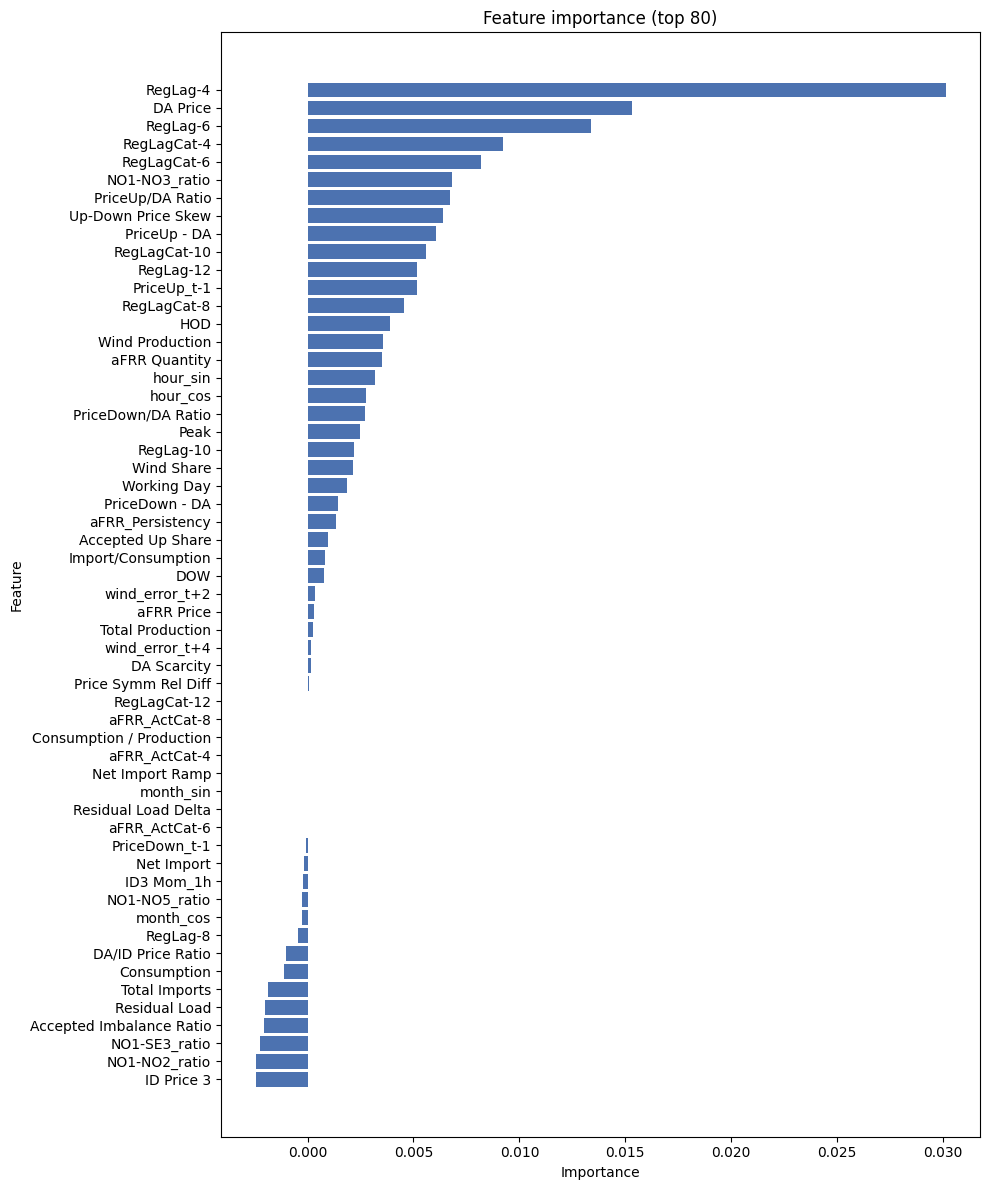

In [294]:
from IPython.display import Markdown, display
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# Show feature importance once using the saved artifact if available,
# otherwise compute quickly as a fallback
fi_csv_path = (MODELS / "feature_importance.csv")
fi_df = None

if fi_csv_path.exists():
    fi_df = pd.read_csv(fi_csv_path)
else:
    try:
        from autogluon.tabular import TabularPredictor
        # Use existing predictor if present, otherwise load it
        predictor = predictor if 'predictor' in globals() else TabularPredictor.load(MODELS)
        # Try to load a cached dataset snapshot for FI; fall back to predictor's training data
        df_path = ROOT / 'reports' / 'dataframes' / 'multiclass_dataset.csv'
        if df_path.exists():
            eval_df = pd.read_csv(df_path)
            # Restrict to model features and drop label
            label = predictor.label
            feature_cols = [c for c in eval_df.columns if c != label and c in predictor.features()]
            eval_df = eval_df[feature_cols].dropna()
        else:
            # If no dataset snapshot, use predictor's training data
            eval_df = predictor.load_data_internal('train')[0]
        # Compute a fast FI with a short time limit
        fi_df = predictor.feature_importance(eval_df, time_limit=30)
    except Exception as e:
        fi_df = None
        print('Feature importance unavailable:', e)

if fi_df is not None and len(fi_df):
    # Normalize schema: ensure a 'feature' column is present
    tmp = fi_df.copy()
    if 'feature' not in tmp.columns:
        if 'Unnamed: 0' in tmp.columns:
            tmp = tmp.rename(columns={'Unnamed: 0': 'feature'})
        else:
            tmp = tmp.reset_index()
            if 'index' in tmp.columns:
                tmp = tmp.rename(columns={'index': 'feature'})
    # Ensure importance column exists
    if 'importance' not in tmp.columns and 'score' in tmp.columns:
        tmp = tmp.rename(columns={'score': 'importance'})

    # Display a single table (top 30)
    top_table = tmp.sort_values('importance', ascending=False).head(100)
    display(Markdown('## Feature importance (top 30)'))
    display(top_table[['feature', 'importance']])

    # Plot a single bar chart (top 80)
    top_plot = tmp.sort_values('importance', ascending=False).head(80)
    plt.figure(figsize=(10, 12))
    plt.barh(top_plot['feature'][::-1], top_plot['importance'][::-1], color='#4C72B0')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature importance (top 80)')
    plt.tight_layout()
    plt.show()
else:
    display(Markdown('## Feature importance unavailable'))





# Imbalance vs. Spot Price

== Class counts and correct predictions ==
true up:      775 | pred up:      638 | correct up:      332
true down:   1589 | pred down:   1724 | correct down:   1060
true none:   2433 | pred none:   2435 | correct none:   1639

== Precision/Recall/F1 per class ==
              precision    recall  f1-score   support

          up       0.52      0.43      0.47       775
        down       0.61      0.67      0.64      1589
        none       0.67      0.67      0.67      2433

    accuracy                           0.63      4797
   macro avg       0.60      0.59      0.59      4797
weighted avg       0.63      0.63      0.63      4797


negatives in UP spread: 0
positives in DOWN spread: 0
--- Up Price - DA | correct UP (delivery) (n=332) ---
mean=20.26, std=12.53, min=0.64, max=100.44
quantiles:
0.05     3.8155
0.25    11.3600
0.50    16.8350
0.75    26.6500
0.95    44.4985
--- Down Price - DA | correct DOWN (delivery) (n=1056) ---
mean=-9.52, std=10.74, min=-136.56, max=-0.02
quantil

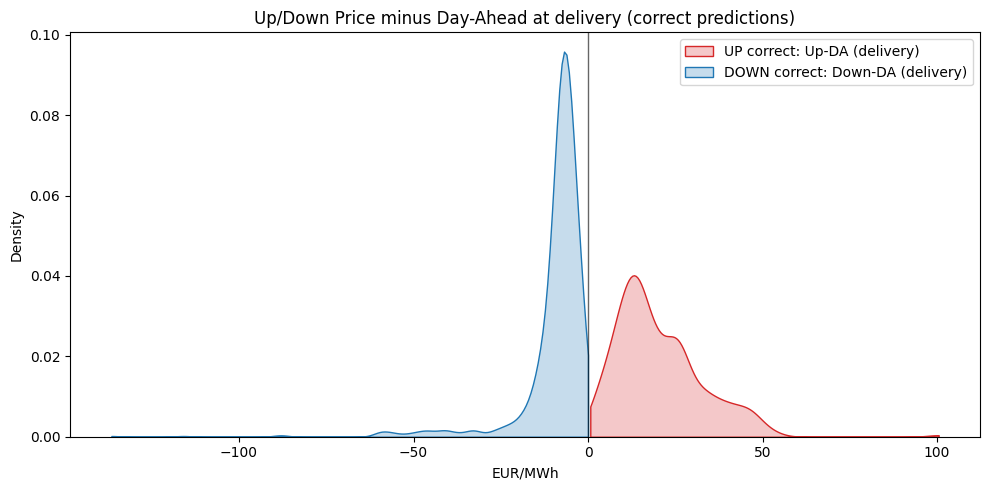

In [295]:
# Up/Down price minus spot (DA) for correct predictions + classification counts
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

# --- paths ---
REPO_ROOT = os.path.abspath(os.path.join('..'))
DATA_DIR = os.path.join(REPO_ROOT, 'data', 'raw')
# Use the same MODELS directory selected above
MODEL_DIR = str(MODELS)

SPLIT = 'test'  # 'val' or 'test'
PRED_FILE = os.path.join(MODEL_DIR, f'{SPLIT}_predictions.csv')

# --- load predictions ---
if not os.path.exists(PRED_FILE):
    raise FileNotFoundError(f'Missing predictions file: {PRED_FILE}')
preds = pd.read_csv(PRED_FILE, index_col=0, parse_dates=True)
preds.index.name = 'Time'
label_col = preds.columns[0]  # e.g., 'RegClass+4'
pred_col = 'pred'
if pred_col not in preds.columns:
    raise ValueError("Expected 'pred' column in predictions CSV")

# Quick counts and confusion summary (uses full predictions, no joins)
y_true = preds[label_col]
y_pred = preds[pred_col]

correct_up = int(((y_pred == 'up') & (y_true == 'up')).sum())
correct_down = int(((y_pred == 'down') & (y_true == 'down')).sum())
correct_none = int(((y_pred == 'none') & (y_true == 'none')).sum())

n_true_up = int((y_true == 'up').sum())
n_true_down = int((y_true == 'down').sum())
n_true_none = int((y_true == 'none').sum())

n_pred_up = int((y_pred == 'up').sum())
n_pred_down = int((y_pred == 'down').sum())
n_pred_none = int((y_pred == 'none').sum())

print('== Class counts and correct predictions ==')
print(f"true up:   {n_true_up:6d} | pred up:   {n_pred_up:6d} | correct up:   {correct_up:6d}")
print(f"true down: {n_true_down:6d} | pred down: {n_pred_down:6d} | correct down: {correct_down:6d}")
print(f"true none: {n_true_none:6d} | pred none: {n_pred_none:6d} | correct none: {correct_none:6d}")

print('\n== Precision/Recall/F1 per class ==')
print(classification_report(y_true, y_pred, labels=['up','down','none'], zero_division=0))

# --- load BalanceMarket prices (Up/Down) ---
def load_balance_market_prices(data_dir: str, include_2024: bool = True) -> pd.DataFrame:
    bm_2025 = os.path.join(data_dir, 'BalanceMarket_2025_NO1_EUR_None_MW.csv')
    bm_2024 = os.path.join(data_dir, 'BalanceMarket_2024_NO1_EUR_None_MW.csv')
    df = pd.read_csv(bm_2025, delimiter=';')
    if include_2024:
        df24 = pd.read_csv(bm_2024, delimiter=';')
        df = pd.concat([df24, df], ignore_index=True)
    df.rename(columns={"Delivery Start (CET)": "Time"}, inplace=True)
    df['Time'] = pd.to_datetime(df['Time'], format='%d.%m.%Y %H:%M:%S')
    df.set_index('Time', inplace=True)
    df = df[~df.index.duplicated(keep='first')].sort_index()
    # Ensure numeric
    for col in ['NO1 Up Price (EUR)', 'NO1 Down Price (EUR)']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df[['NO1 Up Price (EUR)', 'NO1 Down Price (EUR)']]

bm = load_balance_market_prices(DATA_DIR + '/balancing', include_2024=True)

# --- load Day-Ahead (spot proxy) ---
def load_day_ahead_price(data_dir: str, include_2024: bool = True) -> pd.DataFrame:
    da_2025 = os.path.join(data_dir, 'AuctionPrice_2025_DayAhead_NO1_EUR_None.csv')
    da_2024 = os.path.join(data_dir, 'AuctionPrice_2024_DayAhead_NO1_EUR_None.csv')
    da = pd.read_csv(da_2025, delimiter=';')
    if include_2024:
        da24 = pd.read_csv(da_2024, delimiter=';')
        da = pd.concat([da24, da], ignore_index=True)
    da['Delivery Start (CET)'] = pd.to_datetime(da['Delivery Start (CET)'], format='%d.%m.%Y %H:%M:%S')
    da.rename(columns={"Delivery Start (CET)": "Time"}, inplace=True)
    da.set_index('Time', inplace=True)
    da.sort_index(inplace=True)
    da.drop_duplicates(inplace=True)
    col = 'NO1 Price (EUR)'
    da[col] = pd.to_numeric(da[col].replace('', np.nan), errors='coerce')
    da = da[~da.index.duplicated(keep='first')].resample('15min').ffill().bfill()
    da.rename(columns={col: 'DA Price'}, inplace=True)
    return da[['DA Price']]

da = load_day_ahead_price(DATA_DIR + '/prices', include_2024=True)

# --- align and compute delivery-time spreads ---
df = preds[[label_col, pred_col]].join(bm, how='left').join(da, how='left')
# Move to delivery (t+4) to match label horizon
for c in ['NO1 Up Price (EUR)', 'NO1 Down Price (EUR)', 'DA Price']:
    if c in df.columns:
        df[c + ' @delivery'] = df[c].shift(-4)

# Masks for correct predictions
is_up_correct = (df[pred_col] == 'up') & (df[label_col] == 'up')
is_down_correct = (df[pred_col] == 'down') & (df[label_col] == 'down')

# Spreads at delivery
df['Up-DA Spread @delivery'] = df['NO1 Up Price (EUR) @delivery'] - df['DA Price @delivery']
df['Down-DA Spread @delivery'] = df['NO1 Down Price (EUR) @delivery'] - df['DA Price @delivery']

# Percentage change for UP relative to DA at delivery (guard against zero/near-zero DA)
eps = 1e-6
valid_da = (df['DA Price @delivery'].abs() > eps) & (df['DA Price @delivery'] > 20)
up_pct = (df['Up-DA Spread @delivery'] / df['DA Price @delivery']).where(valid_da) * 100.0

spread_up = df.loc[is_up_correct, 'Up-DA Spread @delivery'].dropna()
spread_down = df.loc[is_down_correct, 'Down-DA Spread @delivery'].dropna()
up_pct_correct = up_pct.loc[is_up_correct].dropna()

# Sanity checks
print('\nnegatives in UP spread:', int((spread_up < 0).sum()))
print('positives in DOWN spread:', int((spread_down > 0).sum()))

# --- summarize helper (restored) ---
def summarize(name: str, s: pd.Series) -> None:
    """Print count, mean/std/min/max and key quantiles for a Series."""
    if s is None or len(s) == 0:
        print(f"{name}: no data")
        return
    n = len(s)
    mean = s.mean()
    std = s.std()
    s_min, s_max = s.min(), s.max()
    q = s.quantile([0.05, 0.25, 0.50, 0.75, 0.95])
    print(f"--- {name} (n={n}) ---")
    print(f"mean={mean:.2f}, std={std:.2f}, min={s_min:.2f}, max={s_max:.2f}")
    print("quantiles:")
    print(q.to_string())

# Print summaries again
summarize('Up Price - DA | correct UP (delivery)', spread_up)
summarize('Down Price - DA | correct DOWN (delivery)', spread_down)
summarize('UP % change vs DA | correct UP (delivery) [percent]', up_pct_correct)

# Visualization (boundary-aware KDE)
plt.figure(figsize=(10,5))
sns.kdeplot(spread_up, fill=True, color='#d62728', label='UP correct: Up-DA (delivery)', clip=(0, None), cut=0, bw_adjust=0.8)
sns.kdeplot(spread_down, fill=True, color='#1f77b4', label='DOWN correct: Down-DA (delivery)', clip=(None, 0), cut=0, bw_adjust=0.8)
plt.axvline(0, color='k', lw=1, alpha=0.6)
plt.title('Up/Down Price minus Day-Ahead at delivery (correct predictions)')
plt.xlabel('EUR/MWh')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()


In [296]:
display(Markdown('## Transitions captured from none to up/down'))

# Transitions captured: none -> up / none -> down from t+3 to t+4
import pandas as pd

# y_true is RegClass+4 at index t (class at t+4). Previous step (t+3) is y_true shifted by +1 index.
prev_true = y_true.shift(1)
print(len(preds))

# Masks for transitions from 'none' at t+3 to target at t+4
none_to_up = prev_true.eq('none') & y_true.eq('up')
none_to_down = prev_true.eq('none') & y_true.eq('down')

# Captured by model (predicted correctly at t+4)
captured_up = (none_to_up & y_pred.eq('up')).sum()
cap_total_up = int(none_to_up.sum())
up_pct = (captured_up / cap_total_up * 100.0) if cap_total_up else 0.0

captured_down = (none_to_down & y_pred.eq('down')).sum()
cap_total_down = int(none_to_down.sum())
down_pct = (captured_down / cap_total_down * 100.0) if cap_total_down else 0.0

print(f"None -> Up captured: {captured_up}/{cap_total_up} ({up_pct:.1f}%)")
print(f"None -> Down captured: {captured_down}/{cap_total_down} ({down_pct:.1f}%)")


## Transitions captured from none to up/down

4797
None -> Up captured: 38/189 (20.1%)
None -> Down captured: 122/255 (47.8%)


In [ ]:
# Explore decision policy alpha (up multiplier) and recompute metrics
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, classification_report
from IPython.display import display, Markdown

.0
def _load_predictions(split: str) -> pd.DataFrame:
    """Load saved predictions CSV for the given split (val/test)."""
    path = MODELS / f"{split}_predictions.csv"
    if not path.exists():
        raise FileNotFoundError(f"Missing predictions file: {path}")
    df = pd.read_csv(path)
    return df

.0
def _get_label_and_proba_cols(df: pd.DataFrame):
    # Label column: prefer 'RegClass+4' if present, else the first non-proba, non-'pred'
    label_col = 'RegClass+4' if 'RegClass+4' in df.columns else next(c for c in df.columns if not c.startswith('p_') and c != 'pred')
    proba_cols = [c for c in df.columns if c.startswith('p_')]
    # Ensure required columns exist
    if 'p_up' not in proba_cols:
        raise ValueError("Expected 'p_up' column in predictions (probabilities).")
    return label_col, proba_cols

.0
def predict_with_alpha(df: pd.DataFrame, alpha: float):
    label_col, proba_cols = _get_label_and_proba_cols(df)
    proba = df[proba_cols].copy()
    # Multiply UP probability by alpha then argmax across p_* columns
    proba['p_up'] = proba['p_up'] * float(alpha)
    y_pred = proba.idxmax(axis=1).str.replace('p_', '', regex=False)
    y_true = df[label_col].astype(str)
    return y_true, y_pred

.0
def metrics_for_alpha(df: pd.DataFrame, alpha: float) -> dict:
    y_true, y_pred = predict_with_alpha(df, alpha)
    f1m = f1_score(y_true, y_pred, average='macro', zero_division=0)
    acc = accuracy_score(y_true, y_pred)
    f1_up = f1_score((y_true == 'up'), (y_pred == 'up'), zero_division=0)
    return {'alpha': alpha, 'f1_macro': f1m, 'f1_up': f1_up, 'accuracy': acc}

.0
def sweep_alphas(split: str = 'val', alphas=None) -> pd.DataFrame:
    if alphas is None:
        # A compact sweep around common useful values
        alphas = [0.75, 0.9, 1.0, 1.1, 1.175, 1.25, 1.3, 1.375, 1.45, 1.5, 1.75, 2.0, 2.25, 2.5, 3, 3.5, 4, 4.5, 5, 6, 7]
    df = _load_predictions(split)
    rows = [metrics_for_alpha(df, a) for a in alphas]
    res = pd.DataFrame(rows)
    return res

.0
# Run a quick sweep on validation and test
display(Markdown('## Alpha sweep (validation)'))
val_res = sweep_alphas('val')
display(val_res.sort_values('f1_macro', ascending=False).reset_index(drop=True))

.0
display(Markdown('## Alpha sweep (test)'))
if (MODELS / 'test_predictions.csv').exists():
    test_res = sweep_alphas('test')
    display(test_res.sort_values('f1_macro', ascending=False).reset_index(drop=True))
else:
    print('test_predictions.csv not found; run evaluation to generate it.')

.0
# Optional interactive slider if ipywidgets is available
try:
    import ipywidgets as widgets
    @widgets.interact(alpha=widgets.FloatSlider(min=0.5, max=3.0, step=0.05, value=1.0), split=widgets.ToggleButtons(options=['val','test'], value='val'))
    def interactive_alpha(alpha=1.0, split='val'):
        df = _load_predictions(split)
        m = metrics_for_alpha(df, alpha)
        display(Markdown(f"### Split: {split} | alpha: {alpha:.2f}"))
        print(m)
        # Print a compact report as well
        y_true, y_pred = predict_with_alpha(df, alpha)
        print(classification_report(y_true, y_pred, labels=['up','down','none'], zero_division=0))
except Exception as _e:
    pass

## Alpha sweep (validation)

,alpha,f1_macro,f1_up,accuracy
0,3.500,0.529873,0.297571,0.610173
1,3.000,0.524922,0.274860,0.614968
2,4.000,0.524150,0.295265,0.600167
3,2.500,0.523755,0.264059,0.620388
4,4.500,0.522986,0.305085,0.592037
5,2.250,0.511380,0.226804,0.619137
6,5.000,0.508818,0.291761,0.573275
7,2.000,0.507453,0.210095,0.622055
8,1.750,0.501612,0.187861,0.624557
9,6.000,0.490758,0.290049,0.541797


## Alpha sweep (test)

,alpha,f1_macro,f1_up,accuracy
0,3.000,0.594624,0.461658,0.637690
1,3.500,0.594401,0.469922,0.631853
2,2.500,0.590799,0.444444,0.641234
3,4.000,0.589451,0.464239,0.623932
4,2.250,0.585557,0.426432,0.641443
5,4.500,0.585241,0.460502,0.617052
6,5.000,0.579560,0.457143,0.607671
7,2.000,0.579144,0.405931,0.641443
8,1.750,0.571265,0.381413,0.640609
9,1.500,0.560377,0.349047,0.638316


interactive(children=(FloatSlider(value=1.0, description='alpha', max=3.0, min=0.5, step=0.05), ToggleButtons(…

In [298]:
# Post-hoc confidence & near-miss diagnostics for quick CatBoost run
import os, json
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score

OUT_DIR = r"C:\PythonProjects\rl_reserve_markets\upreg_classify\models\quick_multiclass_cat_hpo"

# Load metrics (if present)
metrics = {}
mp = os.path.join(OUT_DIR, 'metrics.json')
if os.path.exists(mp):
    with open(mp, 'r', encoding='utf-8') as f:
        metrics = json.load(f)


def load_preds(split='test'):
    p = os.path.join(OUT_DIR, f"{split}_predictions.csv")
    if not os.path.exists(p):
        raise FileNotFoundError(p)
    df = pd.read_csv(p)
    label = 'RegClass+4' if 'RegClass+4' in df.columns else None
    if label is None:
        # Heuristic: pick the first non-proba/non-diagnostic column that isn't 'pred'
        drop = {'pred','conf_top1','p_true','margin_to_true','rank_true','top2_has_true','entropy','alpha_needed_true'}
        cand = [c for c in df.columns if c not in drop and not c.startswith('p_')]
        label = cand[0] if cand else None
    if label is None:
        raise RuntimeError('Could not infer label column in predictions file')
    return df, label


def summarize_split(split='test'):
    df, label = load_preds(split)
    # Coerce numerics as needed
    for c in ['conf_top1','p_true','margin_to_true','rank_true','alpha_needed_true']:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')
    if 'top2_has_true' in df.columns:
        df['top2_has_true'] = df['top2_has_true'].astype('boolean')

    y_true = df[label].astype(str)
    y_pred = df['pred'].astype(str)
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average='macro', zero_division=0)

    # Errors
    err = df[y_pred != y_true].copy()
    n = len(df)
    e = len(err)
    near_miss_frac = float((err.get('top2_has_true', pd.Series([np.nan]*e)).fillna(False) == True).mean()) if e else np.nan
    conf_mean = float(err.get('conf_top1', pd.Series(dtype=float)).mean()) if e else np.nan
    conf_median = float(err.get('conf_top1', pd.Series(dtype=float)).median()) if e else np.nan
    alpha_med = float(err.get('alpha_needed_true', pd.Series(dtype=float)).replace([np.inf], np.nan).median()) if e else np.nan
    rank_counts = err.get('rank_true', pd.Series(dtype=float)).value_counts(dropna=False).to_dict() if e else {}

    # Risk-coverage: accuracy and macro-F1 over confidence thresholds
    res = []
    if 'conf_top1' in df.columns:
        for t in [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
            mask = df['conf_top1'] >= t
            cov = float(mask.mean())
            if mask.sum() == 0:
                res.append({'threshold': t, 'coverage': cov, 'acc': np.nan, 'f1_macro': np.nan})
                continue
            yt = y_true[mask]
            yp = y_pred[mask]
            res.append({
                'threshold': t,
                'coverage': cov,
                'acc': float(accuracy_score(yt, yp)),
                'f1_macro': float(f1_score(yt, yp, average='macro', zero_division=0)),
            })
    coverage_df = pd.DataFrame(res)

    # Top confident errors preview
    top_err = err.sort_values('conf_top1', ascending=False).head(10)[[label,'pred','conf_top1','p_true','rank_true','alpha_needed_true']] if e else pd.DataFrame()

    # Combine and print summary
    summary = {
        'split': split,
        'n_rows': n,
        'accuracy': float(acc),
        'f1_macro': float(f1m),
        'n_errors': int(e),
        'errors_top2_has_true_frac': near_miss_frac,
        'errors_conf_top1_mean': conf_mean,
        'errors_conf_top1_median': conf_median,
        'errors_alpha_needed_true_median': alpha_med,
        'errors_rank_true_counts': {str(k): int(v) for k, v in rank_counts.items()},
    }
    if metrics:
        for k in [f'{split}_nll', f'{split}_brier', f'{split}_ece_top1_10bins']:
            if k in metrics:
                summary[k] = metrics[k]

    display(pd.DataFrame([summary]))
    if not coverage_df.empty:
        display(coverage_df)
    if not top_err.empty:
        print('Top confident errors:')
        display(top_err)

# Show VAL and TEST summaries
summarize_split('val')
summarize_split('test')


,split,n_rows,accuracy,f1_macro,n_errors,errors_top2_has_true_frac,errors_conf_top1_mean,errors_conf_top1_median,errors_alpha_needed_true_median,errors_rank_true_counts,val_nll,val_brier,val_ece_top1_10bins
0,val,4316,0.608897,0.555495,1688,0.7891,0.611994,0.609349,2.252175,"{'2': 1184, '3': 356, '1': 148}",0.850355,0.505763,0.047764


,threshold,coverage,acc,f1_macro
0,0.4,0.973355,0.612711,0.542600
1,0.5,0.850324,0.639510,0.507093
2,0.6,0.652919,0.689496,0.494940
3,0.7,0.440686,0.743954,0.506031
4,0.8,0.129518,0.772809,0.290616
5,0.9,0.000000,NaN,NaN


Top confident errors:


,RegClass+4,pred,conf_top1,p_true,rank_true,alpha_needed_true
3860,none,down,0.850527,0.115412,2,7.369483
3861,none,down,0.850527,0.115412,2,7.369483
3848,none,down,0.847055,0.118638,2,7.139822
3870,up,down,0.846384,0.033892,3,24.973120
3084,none,down,0.844522,0.121252,2,6.965004
3101,none,down,0.843706,0.122995,2,6.859667
3099,none,down,0.843706,0.122995,2,6.859667
3082,none,down,0.843685,0.121920,2,6.920015
3871,none,down,0.843075,0.122798,2,6.865531
3083,none,down,0.839845,0.125183,2,6.708956


,split,n_rows,accuracy,f1_macro,n_errors,errors_top2_has_true_frac,errors_conf_top1_mean,errors_conf_top1_median,errors_alpha_needed_true_median,errors_rank_true_counts,test_nll,test_brier,test_ece_top1_10bins
0,test,4318,0.679018,0.646527,1386,0.753247,0.607337,0.606507,2.239673,"{'2': 867, '3': 342, '1': 177}",0.794304,0.462659,0.046988


,threshold,coverage,acc,f1_macro
0,0.4,0.982168,0.683801,0.648802
1,0.5,0.869384,0.711508,0.655303
2,0.6,0.650533,0.742613,0.657654
3,0.7,0.331172,0.751748,0.613787
4,0.8,0.077351,0.778443,0.291807
5,0.9,0.000000,NaN,NaN


Top confident errors:


,RegClass+4,pred,conf_top1,p_true,rank_true,alpha_needed_true
925,none,down,0.848042,0.118966,2,7.128431
924,none,down,0.848042,0.118966,2,7.128431
893,none,down,0.843407,0.121727,2,6.928656
863,up,down,0.837092,0.037924,3,22.073095
862,up,down,0.837092,0.037924,3,22.073095
4197,none,down,0.836554,0.126693,2,6.603019
4196,none,down,0.836353,0.126900,2,6.590674
797,up,down,0.836155,0.035414,3,23.610727
832,none,down,0.833464,0.129531,2,6.434483
793,up,down,0.833212,0.036652,3,22.733221
